# Summary:

#### In this notebook, the trial runs from the preceding notebook ('01_So_What.ipynb') are systematically extended to try to find an optimal configuration for the two models. The model parameters to be fine tuned are: number of epochs, number of layers and the number of units.

#### The best performing model configuration will be used in the notebook '03_Blue_in_Green.ipynb' to analyze the impact of adding noise to the clean dataset.


# Table of contents
* [1. Load modules](#Part1_link)
* [2. Setup data](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1  Clean data](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2  Add noise](#Part2.2_link)
* [3. Setup models and evaluate for various hyper-parameter choices](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Compile and fit LSTM and RNN model](#Part3.1_link)
* [4. Visualize results](#Part4_link)

<a id='Part1_link'></a>
# 1. Load modules

In [1]:
import sys
sys.path.append("../src/")
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd


<a id='Part2_link'></a>
# 2. Setup data

<a id='Part2.1_link'></a>
### 2.1 Noisy data

number of observations in time series: 1820


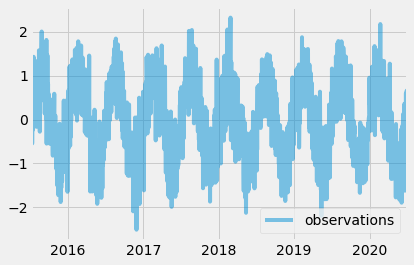

In [8]:
# set a range of dates on which the observations are made
idx = pd.date_range(end='7/1/2020', periods=5*364, freq='d')

# take a sine function as the observations
num_periods = 10  # number of sine periods
observations = [np.sin(2*np.pi*num_periods*x/len(idx)) for x in range(len(idx))]

# generate Gaussian noise

std = 0.5
mean = 0.0
observations = [observations[x] + np.random.normal(loc=mean, scale=std, size=None) for x in range(len(idx))]
print('number of observations in time series: {}'.format(len(observations)))

# initialize dataframe to store time series
df = pd.DataFrame(data={'observations': observations})
df.index = idx

df.plot(alpha=0.5)

The following steps are repeated from the previous notebook, '01_So_What.ipynb', and are grouped into one single step here for simplicity.

In [9]:
# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# load dataframe into object
mdq._selected_features = ['observations']
mdq.df = df

# initialize dataset from dataframe 
mdq.initialize_dataset()

# standardize data
mdq.standardize_data()

# set number of time points for 1/ future forecasting points and 2/ the past, historical time points
future_target_size = int(365/52)
past_history_size = int(1*365)

# generate train and validation data
mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size)


training set shape: x:(909, 365, 1), y:(909, 7, 1)
validation set shape: x:(174, 365, 1), y:(174, 7, 1)


<a id='Part3_link'></a>
# 3. Compile and fit models

<a id='Part3.1_link'></a>
### 3.1 RNN

In [7]:
model_type = 'RNN'

# set number of steps per epoch
num_samples = mdq._num_samples
steps_per_epoch = int(num_samples/future_target_size)
validation_steps = int(steps_per_epoch/2)

units = 128  # number of units in each neural network layer
num_layers = 2  # total number of layers
epochs = 30

# compile model
mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)


In [ ]:
# fit model
mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
              ,validation_steps=validation_steps, model_type=model_type)

# get errors
history = mdq._histories[model_type]
val_mse = history.history['val_mse'][-1]
mse = history.history['mse'][-1]

# get total training time
total_training_time = sum(mdq._time_callbacks[model_type].times)


Epoch 1/30
129/129 [==============================] - 13s 99ms/step - loss: 0.1085 - mse: 0.1085 - val_loss: 0.2357 - val_mse: 0.2357
Epoch 2/30
129/129 [==============================] - 12s 93ms/step - loss: 0.0947 - mse: 0.0947 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 3/30
129/129 [==============================] - 12s 93ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 4/30
129/129 [==============================] - 11s 83ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/30
129/129 [==============================] - 11s 86ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/30
129/129 [==============================] - 11s 87ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 7/30
129/129 [==============================] - 12s 92ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/30
129/129 [==============================] - 12s 97ms

<a id='Part4_link'></a>
# 4. update